In [20]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [2]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

In [3]:
df_avis_up = pd.read_csv("../data/avis_clean.csv")

# II. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [4]:
jeux_cat = df_jeux_up.apply(traitement.extract_categories, axis=1)

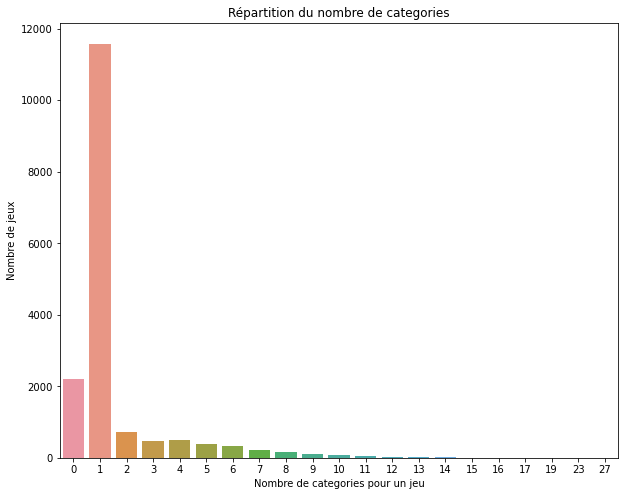

In [5]:
val, count = np.unique(jeux_cat.map(len), return_counts=True)
index = count.argsort()[::-1]
count = count[index]
val = val[index]

plt.figure(figsize=(10, 8))
sns.barplot(val, count)
plt.xlabel("Nombre de categories pour un jeu")
plt.ylabel("Nombre de jeux")
plt.title("Répartition du nombre de categories")
plt.show()

In [6]:
count[val == 0].sum() / len(jeux_cat)

0.13026729093818526

In [7]:
count[val == 1].sum() / len(jeux_cat)

0.6863628281870444

In [8]:
count[val > 1].sum() / len(jeux_cat)

0.18336988087477035

- Les majorités des jeux ont qu'une seule catégorie (68% des jeux), et environ 13% de jeux n'ont pas de catégories. 
- 18% ont plus d'une catégorie.

Avoir plusieurs catégories pour un jeu peut être dérangeant, pour des problèmes de classification entre autres.

In [9]:
cats = []
jeux_cat.map(cats.extend)
u_cats, count_cats = np.unique(cats, return_counts=True)

index = count_cats.argsort()[::-1]
count_cats = count_cats[index]
u_cats = u_cats[index]

In [10]:
print(f"{len(u_cats)} tag de categories")

184 tag de categories


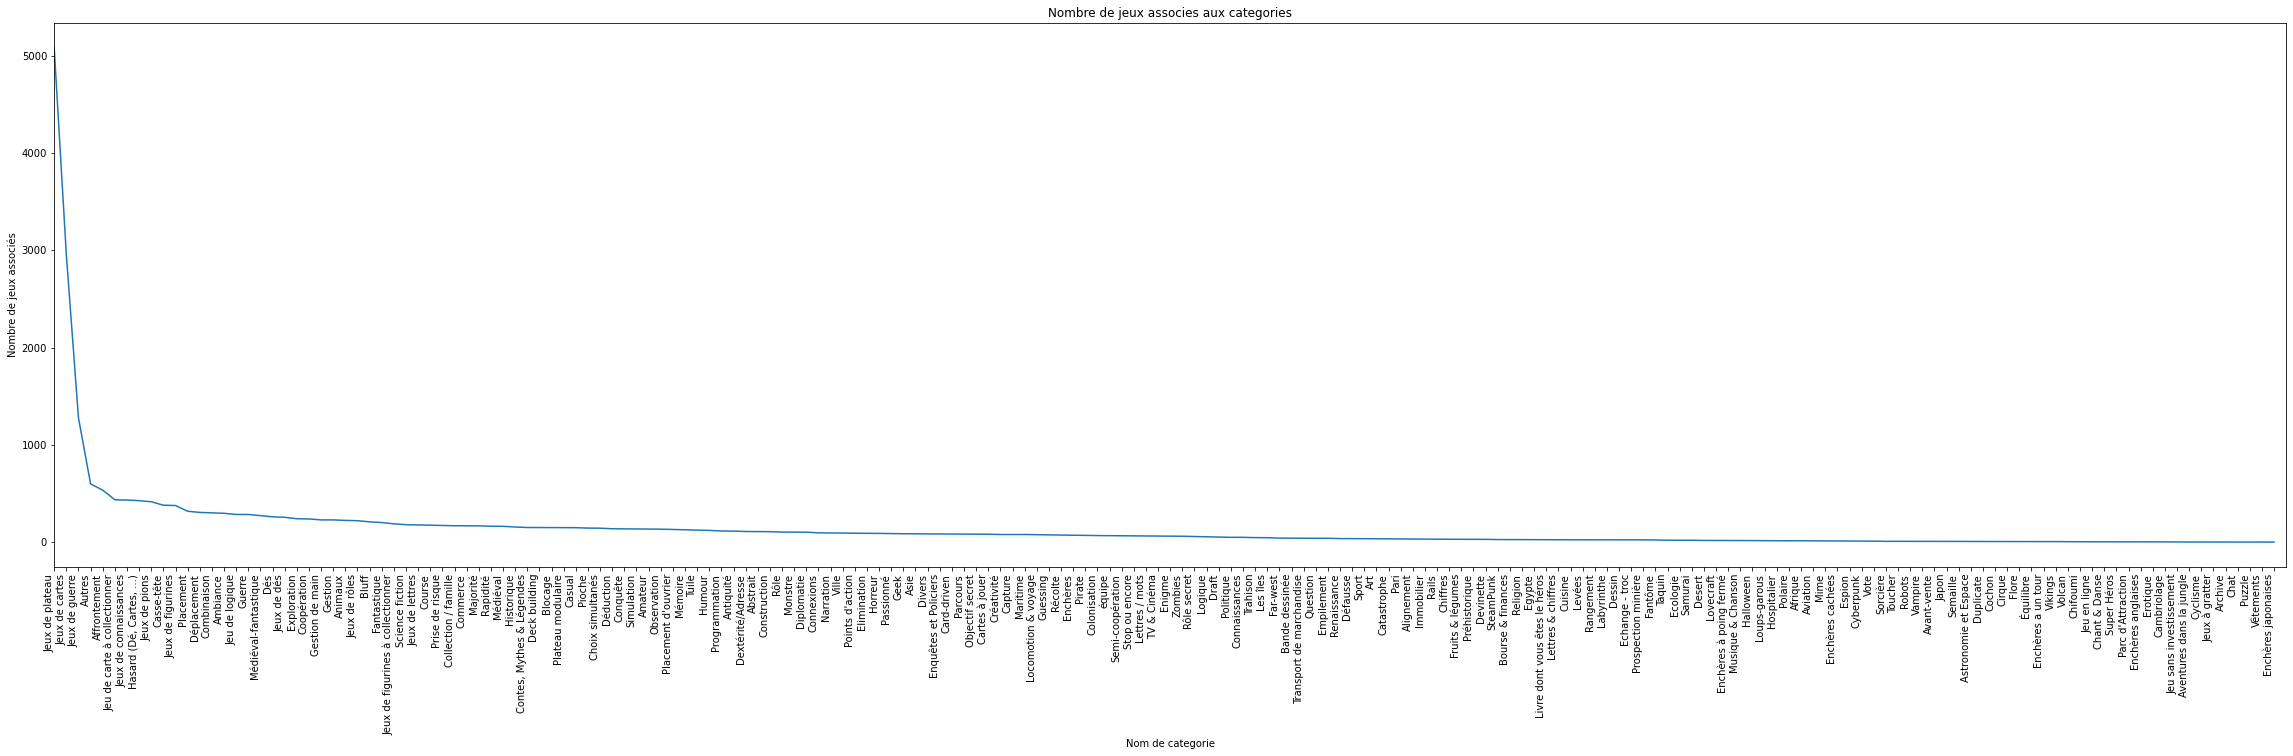

In [11]:
plt.figure(figsize=(40, 10))
plt.plot(u_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(u_cats)))
plt.show()

### 1. Nettoyer les catégories : 

In [12]:
c_cats = []

for cat in u_cats:
    cat_ = preprocessing.clean_text(cat)
    cat_tokens = preprocessing.tokenize_text(cat_)    
    cat_tokens = preprocessing.remove_stopwords(cat_tokens)
    cat_tokens = preprocessing.lemmatize_tokens(cat_tokens)
    cat_ = " ".join(cat_tokens)
    c_cats.append(cat_)

In [13]:
print(f"Apres nettoyage on a {len(np.unique(c_cats))} tag de categorie")

Apres nettoyage on a 174 tag de categorie


#### Mise à jour des categories des jeux

In [14]:
jeux_cat_up = jeux_cat.copy()

for i, row in jeux_cat.iteritems():
    row_ = []
    
    for cat in row:
        index = np.where(u_cats == cat)[0][0]
        row_.append(c_cats[index])
        
    jeux_cat_up[i] = row_

In [15]:
cats = []
jeux_cat_up.map(cats.extend)
uc_cats, count_cats = np.unique(cats, return_counts=True)

index = count_cats.argsort()[::-1]
count_cats = count_cats[index]
uc_cats = uc_cats[index]

### 2. Sélection des N catégories principales : 

On va pondérer les catégories par leur log proba d'apparition pour estimer leur importance, et ainsi sélectionner que les principales.

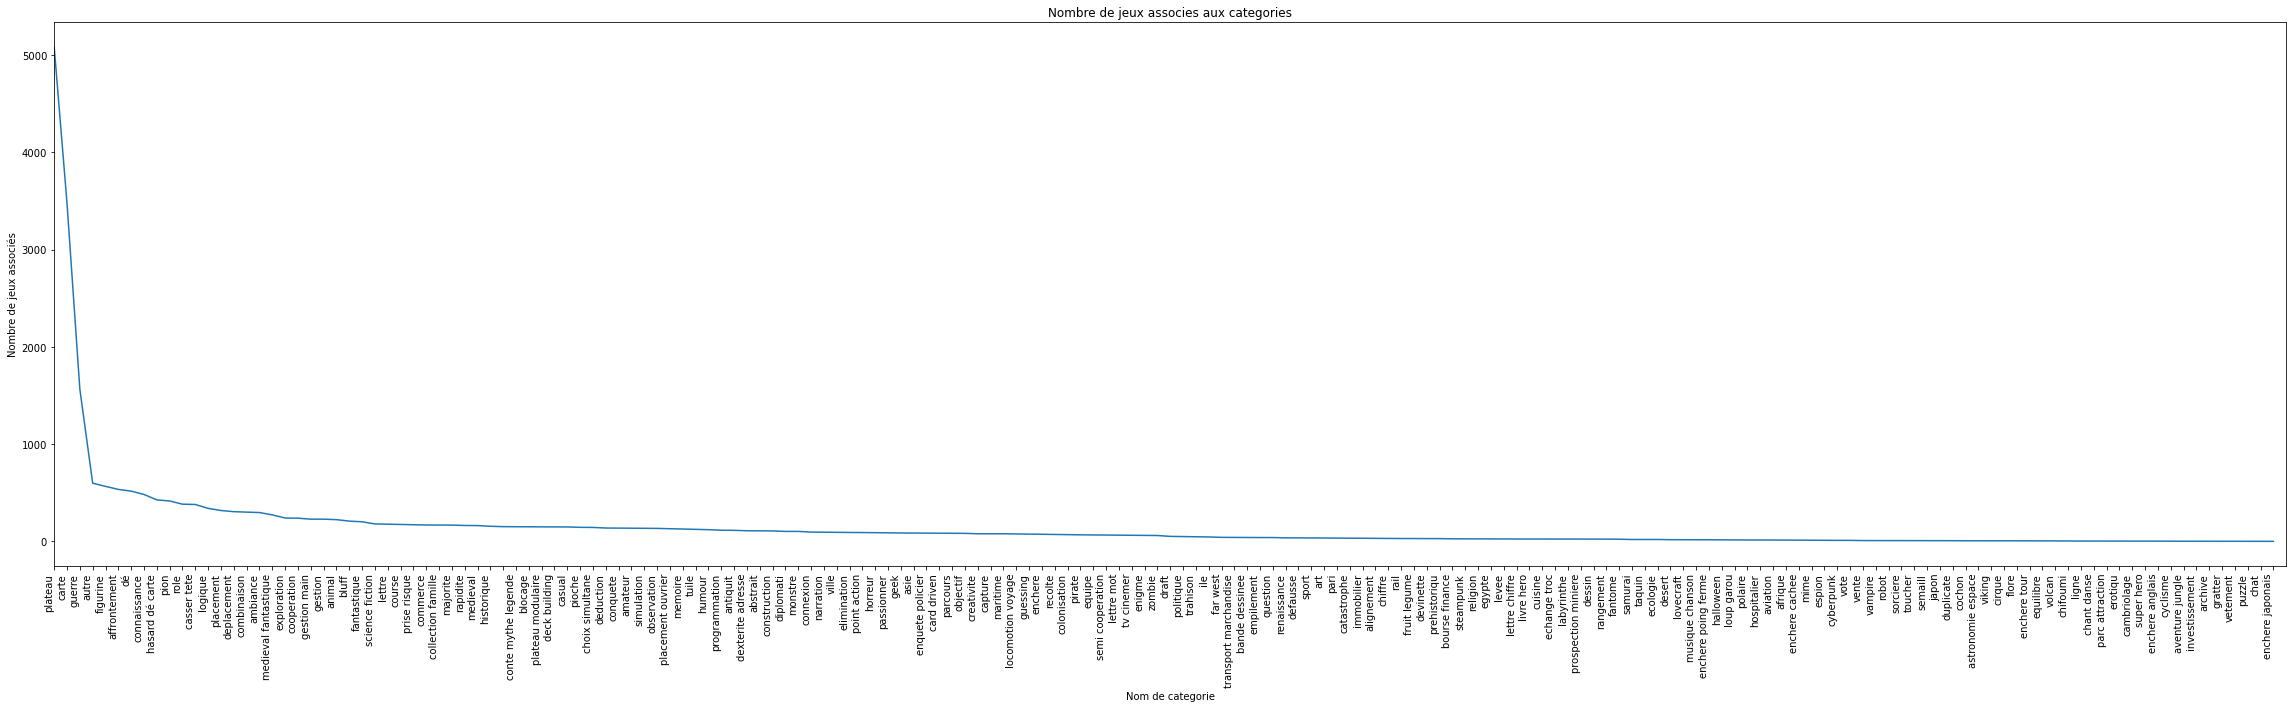

In [16]:
plt.figure(figsize=(40, 10))
plt.plot(uc_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(uc_cats)))
plt.show()

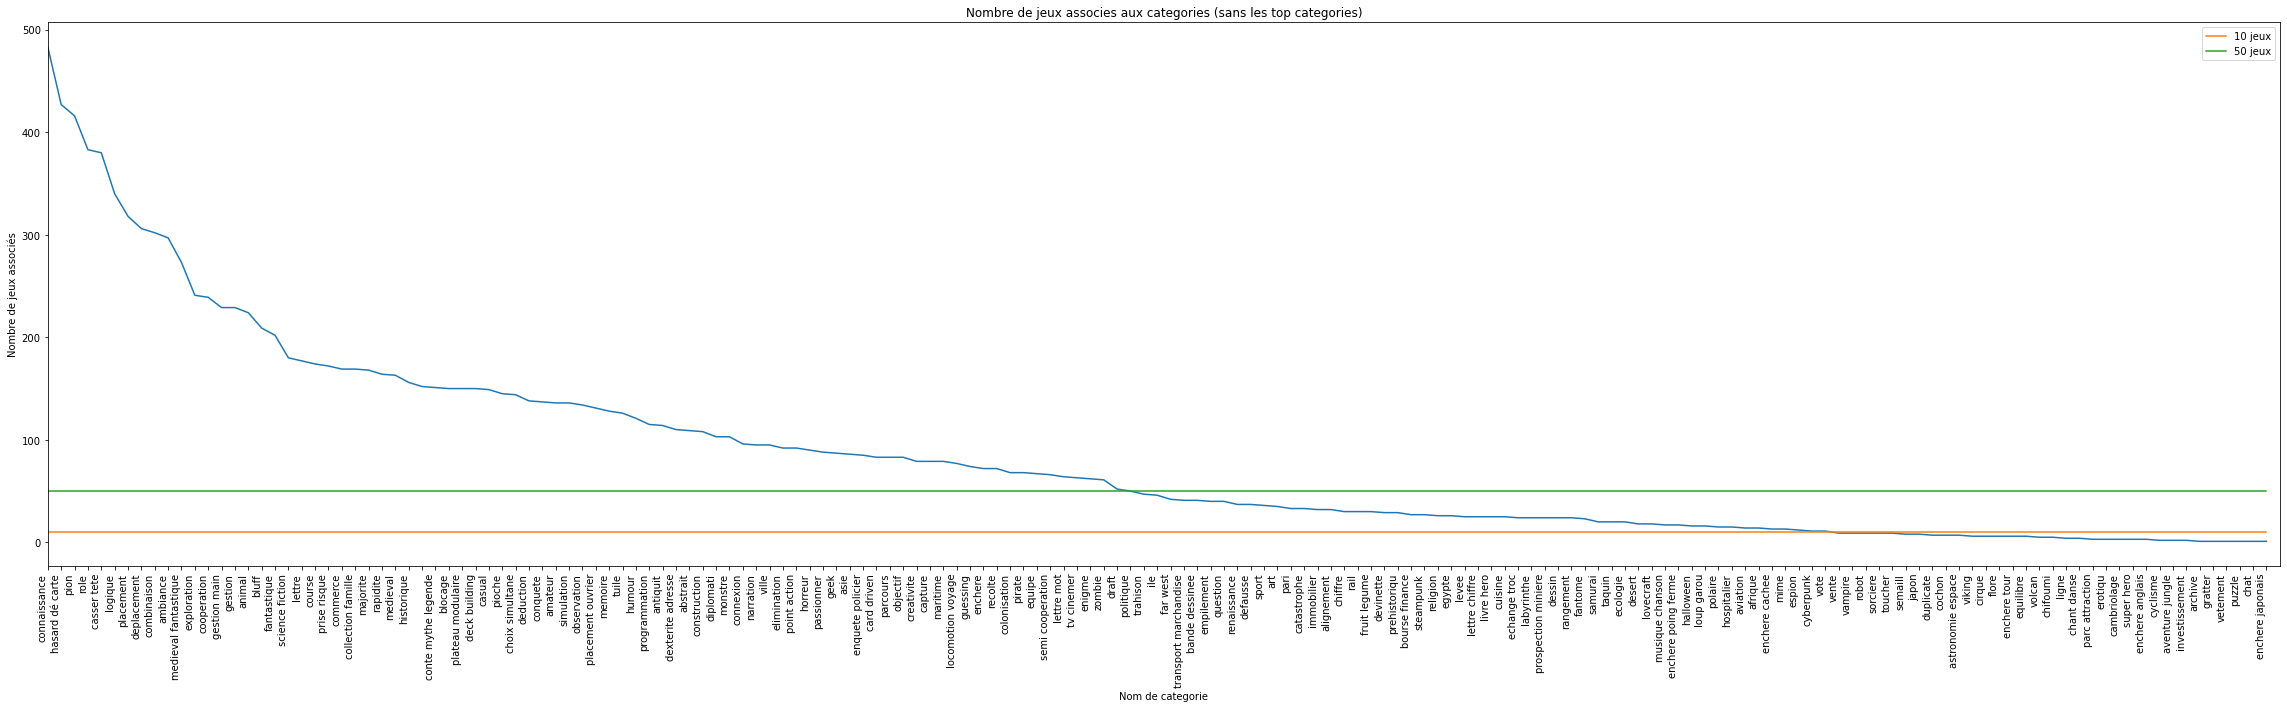

In [17]:
index = count_cats < 500
plt.figure(figsize=(40, 10))
plt.plot(uc_cats[index], count_cats[index])
plt.plot(np.full(len(uc_cats[index]), 10), label="10 jeux")
plt.plot(np.full(len(uc_cats[index]), 50), label="50 jeux")
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories (sans les top categories)")
plt.xlim((0, len(uc_cats[index])))
plt.legend()
plt.show()

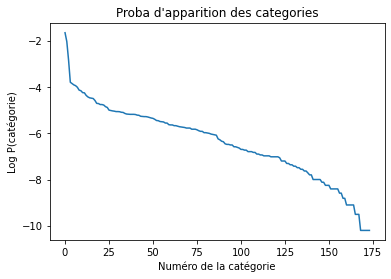

In [18]:
plt.plot(np.log(count_cats / len(cats)))
plt.xlabel("Numéro de la catégorie")
plt.ylabel("Log P(catégorie)")
plt.title("Proba d'apparition des categories")
plt.show()

### TODO : Seuillage ? pour séléctionner les N (remplacer les drop par `autre`)